<a href="https://colab.research.google.com/github/mario-rot/ComputerVisionCourse-MAI/blob/main/Session%208/P8_Mario_Lauren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory #4_1 : Image Classification using CNN

At the end of this laboratory, you would get familiarized with

*   Creating deep networks using Keras
*   Steps necessary in training a neural network
*   Prediction and performance analysis using neural networks
*   Using pre-trained networks
*   Feature visualizations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

# **Colaboratory environment**
By default, Colab notebooks run on CPU.
You can switch your notebook to run with GPU.

In order to obtain access to the GPU, you need to choose the tab Runtime and then select “Change runtime type” as shown in the following figure:

![Changing runtime](https://miro.medium.com/max/747/1*euE7nGZ0uJQcgvkpgvkoQg.png)

When a pop-up window appears select GPU. Ensure “Hardware accelerator” is set to GPU.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%shell
git clone https://github.com/mario-rot/ComputerVisionCourse-MAI.git
cd 'ComputerVisionCourse-MAI'
mv 'customplots.py' /content/
mv 'utils.py' /content/

Cloning into 'ComputerVisionCourse-MAI'...
remote: Enumerating objects: 12241, done.
remote: Counting objects: 100% (662/662), done.
remote: Compressing objects: 100% (522/522), done.
remote: Total 12241 (delta 176), reused 560 (delta 119), pack-reused 11579
Receiving objects: 100% (12241/12241), 81.93 MiB | 22.93 MiB/s, done.
Resolving deltas: 100% (179/179), done.


In [26]:
import os
import numpy as np

from skimage.feature import ORB
from skimage import feature
from skimage.color import rgb2gray
from skimage.io import imread, imread_collection
from scipy.cluster.vq import vq
from sklearn.model_selection import train_test_split
from utils import get_multi_ORB
from sklearn.cluster import MiniBatchKMeans
import collections
import skimage.exposure as ske

from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Resizing
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from customplots import plot_confusion_matrix, custom_grids

# **Working with a new dataset: CIFAR-10**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. More information about CIFAR-10 can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

In Keras, the CIFAR-10 dataset is also preloaded in the form of four Numpy arrays. x_train and y_train contain the training set, while x_test and y_test contain the test data. The images are encoded as Numpy arrays and their corresponding labels ranging from 0 to 9.

Your task is to:

*   Visualize the images in CIFAR-10 dataset. Create a 10 x 10 plot showing 10 random samples from each class.
*   Convert the labels to one-hot encoded form.
*   Normalize the images.




170498071/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3)
4
uint8
(10000, 32, 32, 3)
After reshaping:
(50000, 32, 32, 3)
4
float32
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)


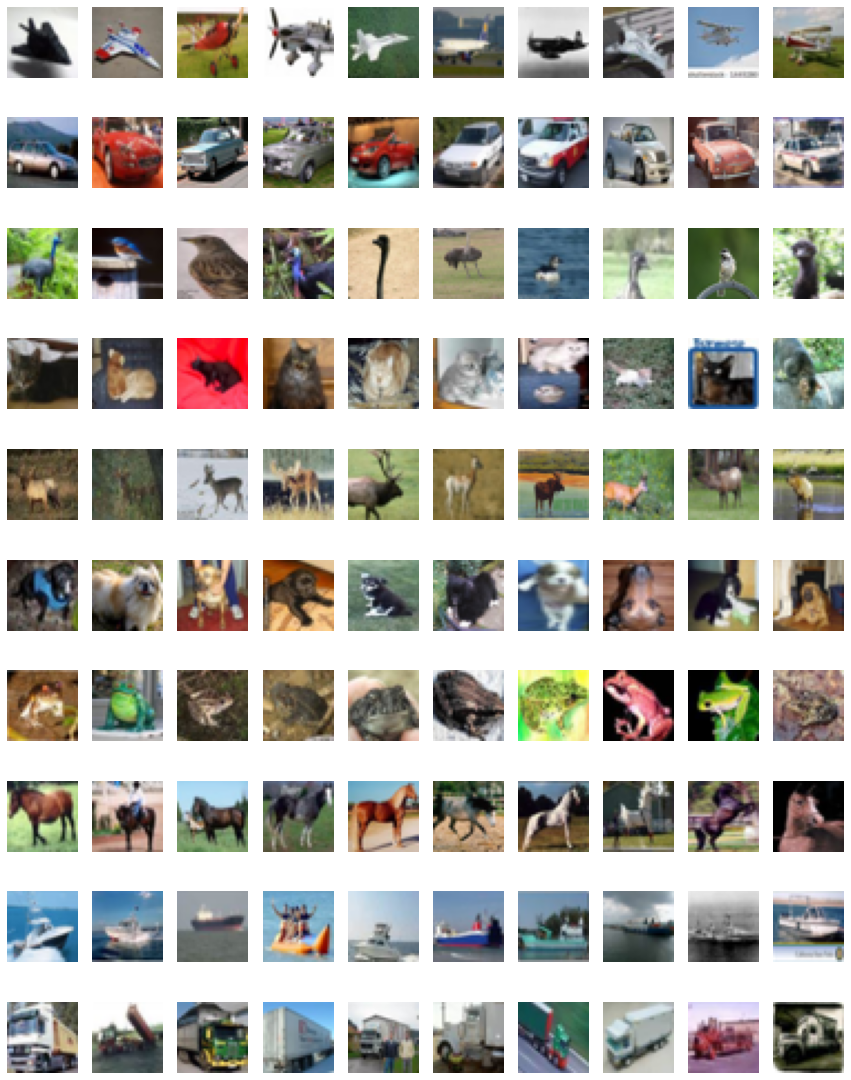

In [4]:
# solution
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


print(x_train.shape)
print(x_train.ndim)
print(x_train.dtype)
print(x_test.shape)

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print('After reshaping:')

print(x_train.shape)
print(x_train.ndim)
print(x_train.dtype)
print(x_test.shape)

y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

print(y_train_cat.shape)
print(y_test_cat.shape)


counters = [10]*10
images = {i:[] for i in range(10)}

for idx, i in enumerate(y_train):
  if counters[i[0]] != 0:
    counters[i[0]] -= 1
    images[i[0]].append(x_train[idx])
  if sum(counters) == 0:
    break

images = [img for sublist in list(images.values()) for img in sublist]

custom_grids(images[0:100], 10, 10, figsize = (15,20), axis='off', use_grid_spec=False).show()

## Define the following model (same as the one in tutorial)

**For the convolutional front-end, start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. Use the input as (32,32,3). The filter maps can then be flattened to provide features to the classifier. Use a dense layer with 100 units before the classification layer (which is also a dense layer with softmax activation).**

In [5]:
from keras.backend import clear_session
clear_session()

In [6]:
# solution

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

*   Compile the model using categorical_crossentropy loss, SGD optimizer and use 'accuracy' as the metric.
*   Use the above defined model to train CIFAR-10 and train the model for 512 epochs with a batch size of 32.

In [7]:
# solution
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train_cat, batch_size=32, epochs=512, validation_split=0.1)

Epoch 1/512
1407/1407 [==============================] - 14s 5ms/step - loss: 1.7760 - accuracy: 0.3665 - val_loss: 1.6324 - val_accuracy: 0.4182
Epoch 2/512
1407/1407 [==============================] - 6s 4ms/step - loss: 1.4476 - accuracy: 0.4878 - val_loss: 1.4034 - val_accuracy: 0.4868
Epoch 3/512
1407/1407 [==============================] - 6s 4ms/step - loss: 1.3000 - accuracy: 0.5421 - val_loss: 1.3020 - val_accuracy: 0.5390
Epoch 4/512
1407/1407 [==============================] - 6s 4ms/step - loss: 1.2012 - accuracy: 0.5788 - val_loss: 1.3215 - val_accuracy: 0.5436
Epoch 5/512
1407/1407 [==============================] - 6s 4ms/step - loss: 1.1322 - accuracy: 0.6064 - val_loss: 1.2312 - val_accuracy: 0.5622
Epoch 6/512
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0748 - accuracy: 0.6255 - val_loss: 1.1441 - val_accuracy: 0.6042
Epoch 7/512
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0242 - accuracy: 0.6426 - val_loss: 1.1374 - val_a

## Defining Deeper Architectures: VGG Models

*   Define a deeper model architecture for CIFAR-10 dataset and train the new model for 512 epochs with a batch size of 32. We will use VGG model as the architecture.

**Stack two convolutional layers with 32 filters, each of 3 x 3. Use a max pooling layer and next flatten the output of the previous layer and add a dense layer with 128 units before the classification layer. For all the layers, use ReLU activation function. Use same padding for the layers to ensure that the height and width of each layer output matches the input**


In [11]:
from keras.backend import clear_session
clear_session()

In [12]:
# solution
model_VGG = Sequential()
model_VGG.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3), padding='same'))
model_VGG.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3), padding='same'))
model_VGG.add(MaxPooling2D((2, 2)))
model_VGG.add(Flatten())
model_VGG.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_VGG.add(Dense(10, activation='softmax'))

*   Compile the model using categorical_crossentropy loss, SGD optimizer and use 'accuracy' as the metric.
*   Use the above defined model to train CIFAR-10 and train the model for 512 epochs with a batch size of 32.

In [13]:
# solution
model_VGG.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history_VGG = model_VGG.fit(x_train, y_train_cat, batch_size=32, epochs=512, validation_split=0.1)


Epoch 1/512
1407/1407 [==============================] - 10s 6ms/step - loss: 1.6862 - accuracy: 0.4006 - val_loss: 1.5339 - val_accuracy: 0.4410
Epoch 2/512
1407/1407 [==============================] - 7s 5ms/step - loss: 1.2885 - accuracy: 0.5459 - val_loss: 1.4184 - val_accuracy: 0.4930
Epoch 3/512
1407/1407 [==============================] - 7s 5ms/step - loss: 1.1162 - accuracy: 0.6097 - val_loss: 1.3923 - val_accuracy: 0.5296
Epoch 4/512
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0005 - accuracy: 0.6523 - val_loss: 1.0793 - val_accuracy: 0.6144
Epoch 5/512
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9087 - accuracy: 0.6826 - val_loss: 1.0109 - val_accuracy: 0.6522
Epoch 6/512
1407/1407 [==============================] - 7s 5ms/step - loss: 0.8294 - accuracy: 0.7127 - val_loss: 0.9752 - val_accuracy: 0.6620
Epoch 7/512
1407/1407 [==============================] - 8s 6ms/step - loss: 0.7557 - accuracy: 0.7394 - val_loss: 1.0260 - val_a

*   Compare the performance of both the models by plotting the loss and accuracy curves of both the training steps. Does the deeper model perform better? Comment on the observation.
 

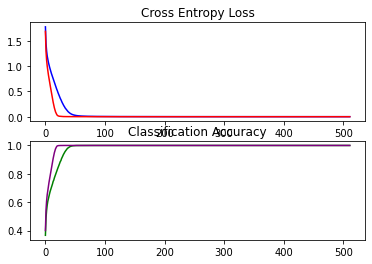

In [14]:
# solution
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history_VGG.history['loss'], color='red', label='VGG train')


plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='train')
plt.plot(history_VGG.history['accuracy'], color='purple', label='VGG train')
plt.show()


**Solution**

*With both models, the model is overfitting the data in very early epochs. However, the deeper model reaches the maximum accuracy in a fewer number of epochs than the more shallow layer.*

...

*   Use predict function to predict the output for the test split
*   Plot the confusion matrix for the new model and comment on the class confusions.


313/313 [==============================] - 1s 3ms/step


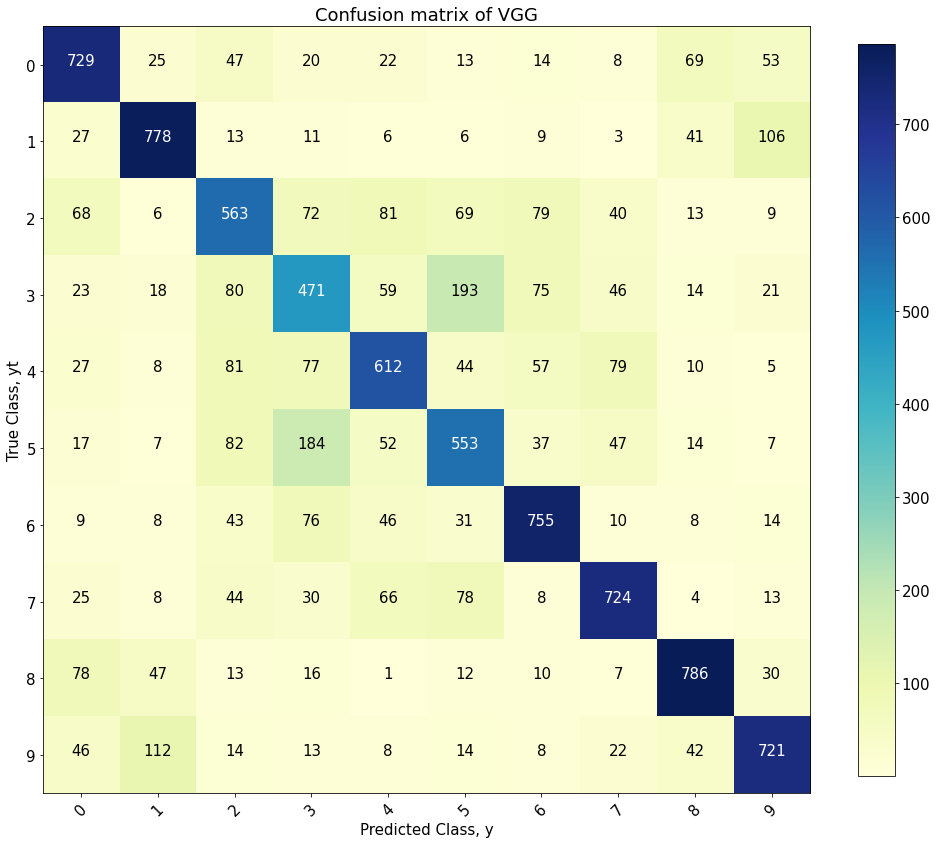

In [15]:
# solution
from customplots import plot_confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

preds = model_VGG.predict(x_test)

predictions = [np.argmax(np.array(pred)) for pred in preds]

plot_confusion_matrix(confusion_matrix(y_test, predictions), list(range(10)), False,'YlGnBu', 'Confusion matrix of VGG')

**Solution**

*(Double-click or enter to edit)*

...

*    Print the test accuracy for the trained model.

In [16]:
# solution
print(accuracy_score(y_test, predictions))

0.6692


## Define the complete VGG architecture.

**Stack two convolutional layers with 64 filters, each of 3 x 3 followed by max pooling layer. Stack two more convolutional layers with 128 filters, each of 3 x 3, followed by max pooling, follwed by two more convolutional layers with 256 filters, each of 3 x 3, followed by max pooling. Flatten the output of the previous layer and add a dense layer with 128 units before the classification layer. For all the layers, use ReLU activation function. Use same padding for the layers to ensure that the height and width of each layer output matches the input**

*   Change the size of input to 64 x 64.

In [17]:
from keras.backend import clear_session
clear_session()

In [20]:
# solution
model_cVGG = Sequential()
model_cVGG.add(Resizing(64,64, input_shape=(32, 32, 3)))
model_cVGG.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 3), padding='same'))
model_cVGG.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 3), padding='same'))
model_cVGG.add(MaxPooling2D((2, 2)))
model_cVGG.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 3), padding='same'))
model_cVGG.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 3), padding='same'))
model_cVGG.add(MaxPooling2D((2, 2)))
model_cVGG.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 3), padding='same'))
model_cVGG.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 3), padding='same'))
model_cVGG.add(MaxPooling2D((2, 2)))
model_cVGG.add(Flatten())
model_cVGG.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_cVGG.add(Dense(10, activation='softmax'))

*   Compile the model using categorical_crossentropy loss, SGD optimizer and use 'accuracy' as the metric.
*   Use the above defined model to train CIFAR-10 and train the model for 100 epochs with a batch size of 32.
*   Predict the output for the test split and plot the confusion matrix for the new model and comment on the class confusions.

Epoch 1/100
1407/1407 [==============================] - 32s 22ms/step - loss: 1.6466 - accuracy: 0.4080 - val_loss: 2.0364 - val_accuracy: 0.3746
Epoch 2/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1.1921 - accuracy: 0.5801 - val_loss: 1.1402 - val_accuracy: 0.5866
Epoch 3/100
1407/1407 [==============================] - 32s 22ms/step - loss: 0.9543 - accuracy: 0.6681 - val_loss: 0.9480 - val_accuracy: 0.6738
Epoch 4/100
1407/1407 [==============================] - 30s 21ms/step - loss: 0.7844 - accuracy: 0.7281 - val_loss: 0.9378 - val_accuracy: 0.6762
Epoch 5/100
1407/1407 [==============================] - 30s 21ms/step - loss: 0.6408 - accuracy: 0.7774 - val_loss: 0.9216 - val_accuracy: 0.6964
Epoch 6/100
1407/1407 [==============================] - 30s 21ms/step - loss: 0.5009 - accuracy: 0.8254 - val_loss: 0.9004 - val_accuracy: 0.7044
Epoch 7/100
1407/1407 [==============================] - 30s 21ms/step - loss: 0.3714 - accuracy: 0.8717 - val_loss: 1

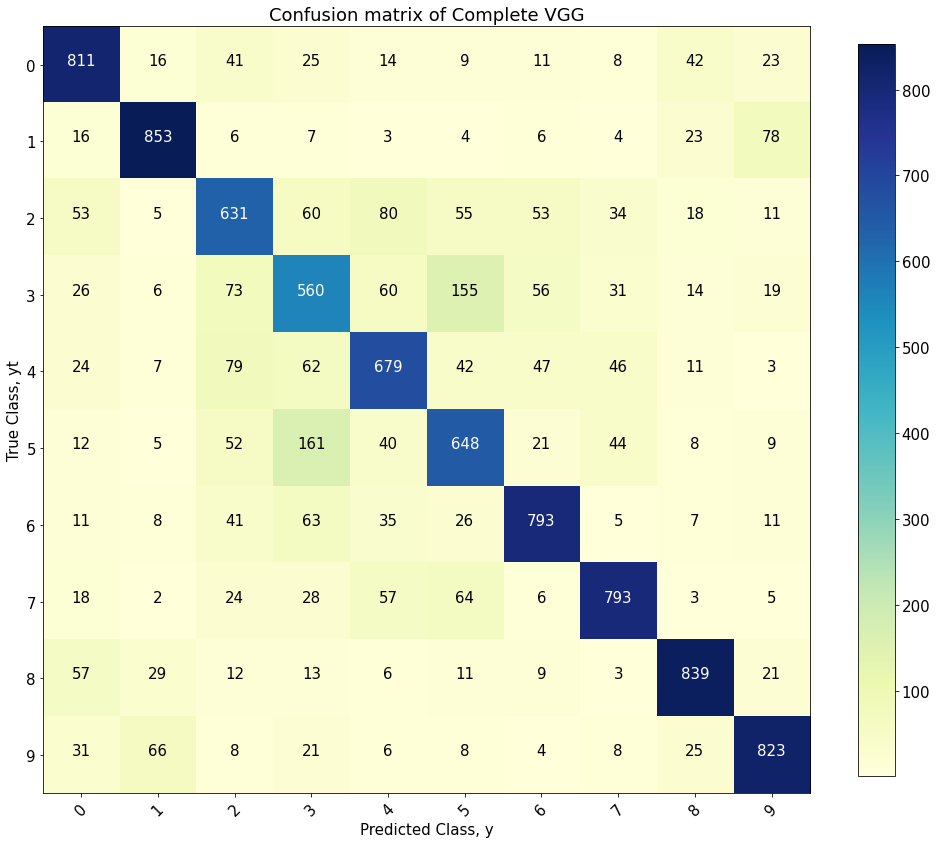

In [21]:
# solution
model_cVGG.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history_cVGG = model_cVGG.fit(x_train, y_train_cat, batch_size=32, epochs=100, validation_split=0.1)

preds = model_cVGG.predict(x_test)

predictions = [np.argmax(np.array(pred)) for pred in preds]

plot_confusion_matrix(confusion_matrix(y_test, predictions), list(range(10)), False,'YlGnBu', 'Confusion matrix of Complete VGG')


# Understanding deep networks

*   What is the use of activation functions in network? Why is it needed?
*   We have used softmax activation function in the exercise. There are other activation functions available too. What is the difference between sigmoid activation and softmax activation?
*   What is the difference between categorical crossentropy and binary crossentropy loss?

**Solution**

*(Double-click or enter to edit)*

...

# Transfer Learning

It is not always necessary to train models from scratch. We can use the knowledge of networks trained on other tasks to learn the task at hand. In this exercise, we will explore the use of pre-trained weights and train on the CIFAR-10 dataset.

*   Create a base imagenet pretrained InceptionV3 model.
    *    Hint: Use tf.keras.applications to create the model
    *    Pay attention to the include_top parameter.


In [32]:
from keras.backend import clear_session
clear_session()

In [33]:
# solution
inception = keras.applications.inception_v3.InceptionV3(include_top=False, input_shape=(75,75,3))

*    Add a global average pooling layer, followed by a fully-connected layer with 1024 neurons and then the classification layer.

In [34]:
# solution
classifier =  Sequential((GlobalAveragePooling2D(),
                          Dense(1024, activation='relu', kernel_initializer='he_uniform'),
                          Dense(10, activation='softmax')))

*   Train the model by freezing the base model. Train only the newly added layers.
    *    Hint: Every layer has an attribute called 'trainable'
*   Compile the model and train the model for a few epochs only.

In [35]:
# solution
input_layer = keras.layers.Input(shape=(32, 32, 3))
resizing_layer = Resizing(75,75)(input_layer)
base_layers = inception(resizing_layer, training=False)
bottom_layers = classifier(base_layers)

model_tl = Model(input_layer, bottom_layers)

inception.trainable = False

model_tl.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

model_tl.summary()

history_tl = model_tl.fit(x_train, y_train_cat, batch_size=32, epochs=10, validation_split=0.1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 75, 75, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 10)                2108426   
                                                                 
Total params: 23,911,210
Trainable params: 2,108,426
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/10
1407/1407 [==============================] - 38s 23ms/step - loss: 1.3720 - accuracy: 0.5255 - val_loss: 1.2526 - val_accuracy: 0.5644
Epoch 2/10
1407/1407 [=====

*    Freeze the bottom layers and unfreeze the base layers.
*    Compile and train the classifier with a very low learning rate (0.0001)

In [36]:
# solution
for layer in model_tl.layers:
    layer.trainable = False
inception.trainable = True

model_tl.summary()
model_tl.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history_tl = model_tl.fit(x_train, y_train_cat, batch_size=32, epochs=10, validation_split=0.1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 75, 75, 3)         0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 10)                2108426   
                                                                 
Total params: 23,911,210
Trainable params: 21,768,352
Non-trainable params: 2,142,858
_________________________________________________________________
Epoch 1/10
1407/1407 [==============================] - 83s 54ms/step - loss: 0.6016 - accuracy: 0.7916 - val_loss: 0.9849 - val_accuracy: 0.6742
Epoch 2/10
1407/1407 [=====

*    Compare the performance of the VGG model and the Inception-V3 model.

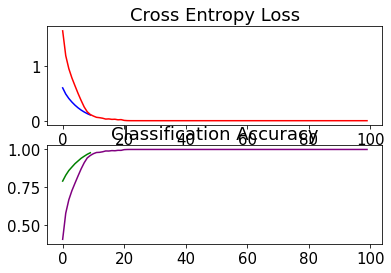

In [38]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history_tl.history['loss'], color='blue', label='Inception-V3 train')
plt.plot(history_cVGG.history['loss'], color='red', label='VGG train')


plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history_tl.history['accuracy'], color='green', label='Inception-V3 train')
plt.plot(history_cVGG.history['accuracy'], color='purple', label='VGG train')
plt.show()

313/313 [==============================] - 5s 15ms/step


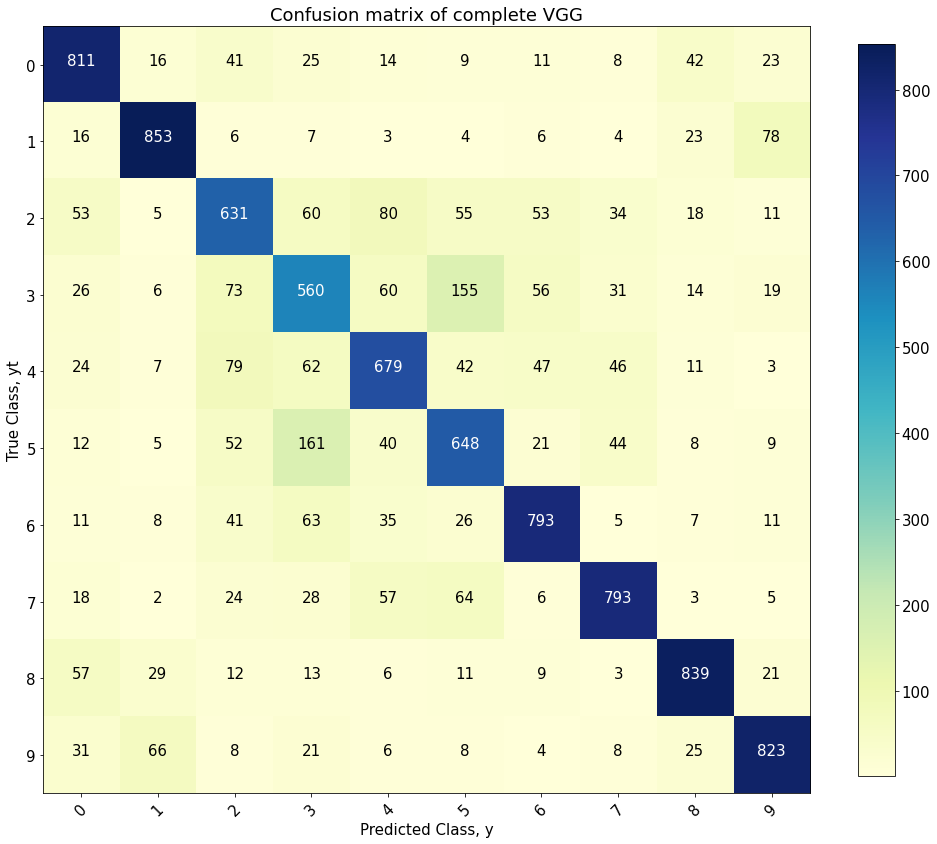

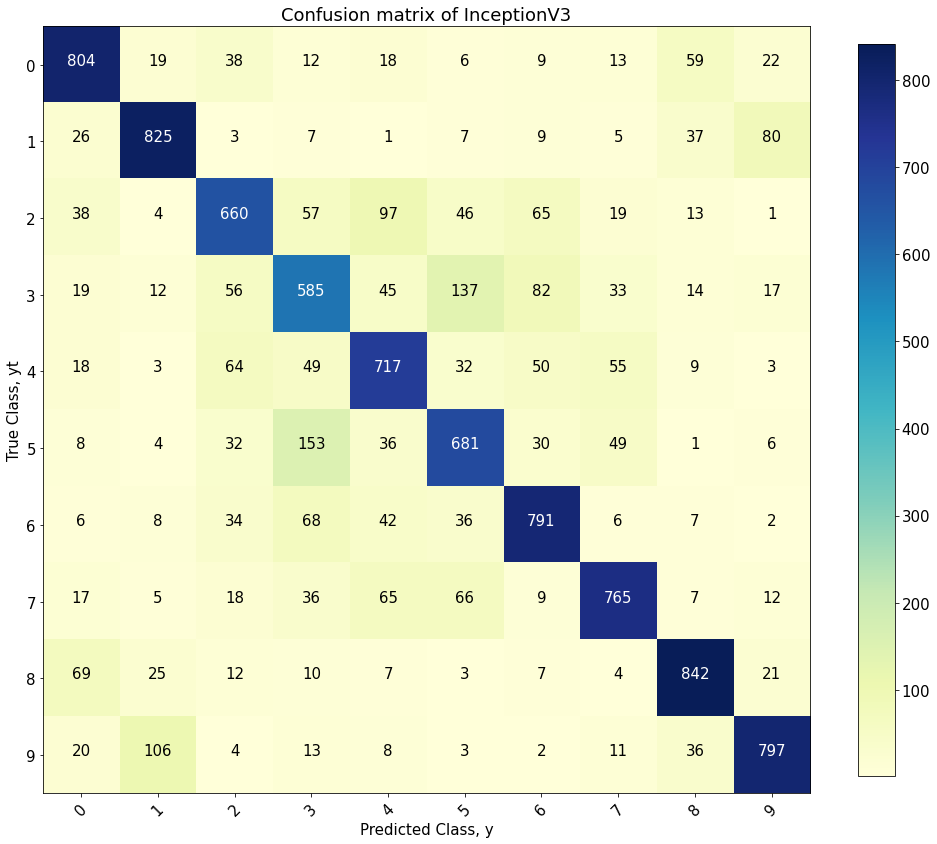

In [45]:
preds_cVGG = model_cVGG.predict(x_test)
preds_Incep = model_tl.predict(x_test)

predictions_cVGG = [np.argmax(np.array(pred)) for pred in preds_cVGG]
predictions_Incep = [np.argmax(np.array(pred)) for pred in preds_Incep]

plot_confusion_matrix(confusion_matrix(y_test, predictions_cVGG), list(range(10)), False,'YlGnBu', 'Confusion matrix of complete VGG')
plot_confusion_matrix(confusion_matrix(y_test, predictions_Incep), list(range(10)), False,'YlGnBu', 'Confusion matrix of InceptionV3')

In [41]:
print('Complete VGG Accuracy: ', accuracy_score(y_test, predictions_cVGG))
print('InceptionV3 Accuracy: ', accuracy_score(y_test, predictions_Incep))

Complete VGG Accuracy:  0.743
InceptionV3 Accuracy:  0.7467


In [44]:
print('Classification_report VGG Accuracy: \n', classification_report(y_test, predictions_cVGG))
print('Classification_report InceptionV3 Accuracy: \n', classification_report(y_test, predictions_Incep))

Classification_report VGG Accuracy: 
               precision    recall  f1-score   support

           0       0.77      0.81      0.79      1000
           1       0.86      0.85      0.85      1000
           2       0.65      0.63      0.64      1000
           3       0.56      0.56      0.56      1000
           4       0.69      0.68      0.69      1000
           5       0.63      0.65      0.64      1000
           6       0.79      0.79      0.79      1000
           7       0.81      0.79      0.80      1000
           8       0.85      0.84      0.84      1000
           9       0.82      0.82      0.82      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

Classification_report InceptionV3 Accuracy: 
               precision    recall  f1-score   support

           0       0.78      0.80      0.79      1000
           1       0.82      0.82      0.82     

**Solution**

*(Double-click or enter to edit)*

...

*    When do we train models from scratch? What are the potential issues in training models from scratch?

**Solution**

*(Double-click or enter to edit)*

...

*    Why do we use pre-trained weights?
*    What is the difference between using random initialization and using weights from a pre-trained model?

**Solution**

*(Double-click or enter to edit)*

...

# Extracting features from Deep Networks

It is quite possible to extract features (similar to SIFT or ORB) from different layers of deep network.

*   Load ResNet50 model with imagenet weights and check the summary of the model
*   Create a model to extract features from the 'avg_pool' layer.
*   Extract features from the layer for all the train images.
*   Use the extracted features to train a SVM classifier.
    *    Use GridSearchCV and SVC to perform the classification

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
# solution
from keras.models import Model

model_rn = Sequential()
model_rn.add(Resizing(224, 224))
rn = tf.keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_shape=(224, 224, 3))
feature_extraction_model = Model(rn.input, rn.layers[-2].output)
model_rn.add(feature_extraction_model)
# print(rn.layers[-2])
# model_rn.add(tf.keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_shape=(224, 224, 3)))
model_rn.trainable = False
model_rn.build(input_shape=(None,224, 224, 3))
model_rn.summary()
#rn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
extracted_features = model_rn.predict(x_train)

1563/1563 [==============================] - 136s 87ms/step


In [ ]:
extracted_features.shape

(50000, 2048)

In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(extracted_features, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*    Evaluate the trained SVM model using the test set
*    Calculate the accuracy score and confusion matrix

In [ ]:
# solution



# Feature Visualizations

In order to visualize the features of a higher dimension data, t-SNE is used. t-SNE converts the affinities of the data points to probabilities. It recreates the probability distribution in a low-dimensional space. It is very helpful in visualizing features of different layers in a neural network.

You can find more information about t-SNE [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)

*    Use TSNE to visualize the features extracted in the previous exercise.
    *    Hint: TSNE function is available in the *sklearn.manifold* package.

In [ ]:
# solution



*    Why is feature visualization helpful?

**Solution**

*(Double-click or enter to edit)*

...


---

## **End of P4_1: Image Classification using CNN**
Deadline for P4_1 submission in CampusVirtual is: **Monday, the 24th of November, 2022**